# Goals of this Notebook

- combine Story's and my analysis into one pipeline
- analyze and highlight differences between Story's and my analysis, make it easy to transition between the two with the change of a parameter

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from typing import *

import sys
import os 
sys.path.append(os.path.abspath("../frbfuncs/"))
import cosmology as c 
import deprecated_cosmology as d
import ktau as kt

# Data

## variables to use:
- Story's dataset: dm, fluence, min_fluence, snr
- new CHIME dataset: dm_new, fluence_new, min_fluence_new, snr_new

In [2]:
import cfod
from cfod import catalog
CHIME = catalog.as_dataframe()

#### unpack FRB-cat1 data published by CHIME ####

snr, dm, fluence, fluence_err, = np.loadtxt(
    './data/chimefrbcat1.csv', skiprows=1, usecols=(17, 18, 34, 35), delimiter=',', unpack=True)

## note: low_ft_95, up_ft_95, flux, flux_err, fluence_err never used
##       tns, fluence_notes are never used
## only snr, dm, fluence are relevant

#### define minimmum fluence for each event #####

MIN_SNR = 12 # approx. threshold, according to CHIME's cat1 paper
min_fluence = fluence * (MIN_SNR / snr) # scale reported fluence 'snr' by SNR ratio
del fluence_err

dm_new = np.array(CHIME['dm_fitb'])
snr_new = np.array(CHIME['snr_fitb'])
fluence_new = np.array(CHIME['fluence'])
min_fluence_new = fluence_new * MIN_SNR/snr_new
del CHIME, MIN_SNR, catalog

# Implementation

In [3]:
#using story's z_DM function
rs_story = kt.get_z_story(dm)
rs_new_story = kt.get_z_story(dm_new)

#using my z_DM function
rs = kt.get_z(dm, func="Zhang")
rs_new = kt.get_z(dm_new, func="Zhang")

#story's data
storydata = [fluence, min_fluence, dm, rs, rs_story]

#latest CHIME catalog data
newdata = [fluence_new, min_fluence_new, dm_new, rs_new, rs_new_story]

print("data all prepared")

data all prepared


Text(0.5, 0, 'DM')

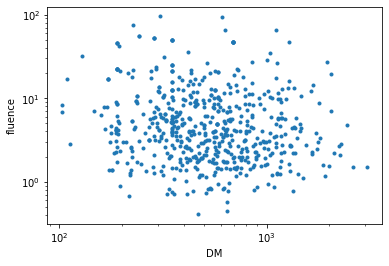

In [4]:
plt.scatter(dm_new, fluence_new, marker='.')
#plt.scatter(dm_new, fluence_new, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('fluence')
plt.xlabel('DM')
#plt.ylim([2e0, 2e1])

(1, 5)

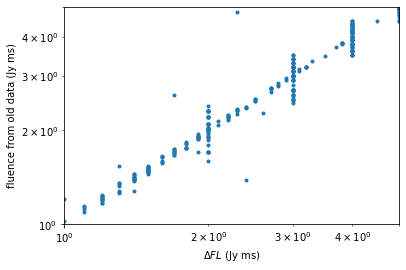

In [5]:
plt.scatter(fluence, fluence_new[:-1], marker='.')
plt.xlabel('$\Delta FL$ (Jy ms)')
plt.ylabel('fluence from old data (Jy ms)')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1,5])
plt.xlim([1,5])

In [6]:
def ktau_data_options(data = "new", z_DM = "mine", alpha = 1):
    #data = "new" or data = "story"
    data = storydata if (data == "story") else newdata
    FL = data[0]
    MIN_FL = data[1]
    DM = data[2]
    
    #z_DM = "mine" or z_DM = "story"
    ZS = data[4] if (z_DM == "story") else data[3]
    
    #alpha is adjustable
    LUM = kt.get_L(FL, ZS, alpha=alpha)
    MIN_LUM = kt.get_L(MIN_FL, ZS, alpha=alpha)
    
    return LUM, MIN_LUM, ZS

### testing

In [7]:
#import importlib as i
#i.reload(kt)

In [16]:
#newest data and all
lum, min_lum, zs = ktau_data_options(data = "story", z_DM = "story", alpha=1)
lum1, min_lum1, zs1 = ktau_data_options(data = "new", z_DM = "story", alpha=1)

#orig = min_lum
#min_lum, lum = c.sort_by_first(min_lum, lum)
#orig, zs = c.sort_by_first(min_lum, zs)

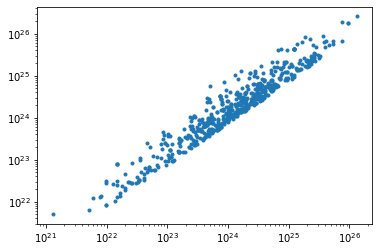

In [17]:
plt.scatter(min_lum, lum, marker='.')
plt.yscale('log')
plt.xscale('log')

In [18]:
g_space = np.linspace(2, 4, 20)
y = np.zeros(len(g_space))
y_ = np.zeros(len(g_space))

for i, val in enumerate(g_space):
    y[i] = kt.ktau_E(lum, min_lum, zs, gfunc=kt.g_complex, k=val, params="default") #using default
    y_[i] = kt.ktau_E(lum1, min_lum1, zs1, gfunc=kt.g_complex, k=val, params="default") #using default

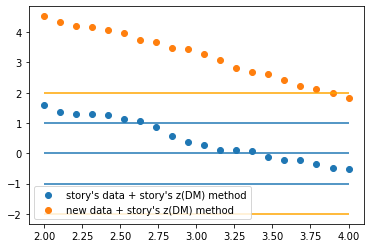

In [19]:
plt.scatter(g_space, y, label='story\'s data + story\'s z(DM) method')
plt.scatter(g_space, y_, label='new data + story\'s z(DM) method')
plt.legend()
plt.hlines([-1,0,1], 2.0, 4)
plt.hlines([-2,2], 2, 4, color='orange')
plt.show()

# Differences in Kendall Tau Implementation

## TODO
- use dataset without ties (DONE)
- break ties arbitrarily
- try different alpha values (DONE)
- use original $g(z,k)$ function (DONE)
- obtain working value of $k$, begin working from there
- can mention ASKAP and Parkes in paper, but CHIME clearly has more data. can see if those give similar results; if so, encouraging.

## More Stuff
- (optional) re-run simulations for kendall tau, can be included as an appendix for how good the Efron-Petrosian method is


# GRB Data

In [111]:
GRB = pd.read_csv('./data/grbdata.csv')
GRB.describe()

,z,lum,k_corr
count,207.000000,207.000000,207.000000
mean,1.941758,55.990817,1.962190
std,1.193484,91.936406,1.520118
min,0.080000,0.004265,0.282107
25%,1.021500,8.552825,1.182305
50%,1.710000,27.833735,1.573390
75%,2.680500,66.983106,2.319775
max,6.600000,748.630410,16.389100


In [112]:
GRB

,z,lum,k_corr
0,1.2900,2.489008,1.796250
1,0.5915,0.585549,1.128310
2,1.9490,27.833735,0.936159
3,1.4400,15.911290,2.010240
4,3.2400,77.641040,1.001730
5,2.9000,344.034370,2.145210
6,0.6535,2.921100,1.899690
7,4.2700,97.608057,2.678490
8,0.2580,1.459770,1.080720
9,1.3800,13.067029,1.030900


In [138]:
z_grb = np.array(GRB['z'])
L_grb = np.array(GRB['lum'])*1e50/np.array(GRB['k_corr'])

def L_lim(F, z):
    return F*4*np.pi*(c.D_L(z)*c.c/c.H_0 * 1e2)**2

min_L_grb = L_lim(2e-8, z_grb)/#/np.array(GRB['k_corr'])
#min_L_grb = c.E_v(np.full(len(z_grb), 12), z_grb, alpha=1)

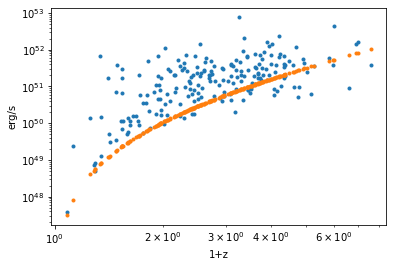

In [139]:
plt.scatter(1+z_grb, L_grb, marker='.')
plt.scatter(1+z_grb, min_L_grb, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('erg/s')
plt.xlabel('1+z')
plt.show()

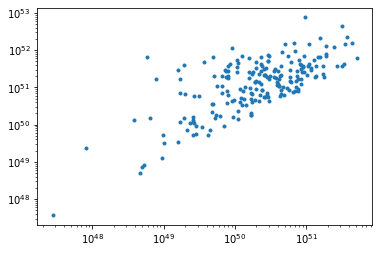

In [119]:
plt.scatter(min_L_grb, L_grb, marker='.')
plt.yscale('log')
plt.xscale('log')

In [ ]:
def g_complex(z: Union[float, np.ndarray], k: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    Z = 1+z
    n = _SHARPNESS
    return Z**k/(1+(Z/_Z_CR)**n)**(k/n)

In [136]:
g_space = np.linspace(1, 4, 20)
testy = np.zeros(len(g_space))

for i, val in enumerate(g_space):
    testy[i] = kt.ktau_E(L_grb, min_L_grb, z_grb, gfunc=kt.g_complex, k=val, params="default") #using default

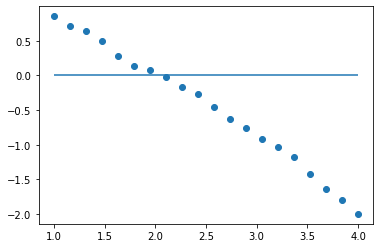

In [137]:
plt.scatter(g_space, testy)
plt.hlines(0, 1, 4)

# TASKS

- check: simulate data with well defined distibutions. perhaps (1+z)^k evolution to be simple
- check grb paper f bands or whatever